In [1]:
import os
import pretty_midi
import json
import numpy as np
import matplotlib.pyplot as plt
import random
import pygame

os.environ['CUDA_VISIBLE_DEVICES'] = '5,6'


pygame 2.6.1 (SDL 2.28.4, Python 3.8.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# load data
# path = "../../dataset/midi_dataset/filtered_midi_imgs_small.npy"
path = "../../dataset/quickdraw_dataset/eye_100.npy"
img_data = np.load(path, allow_pickle=True,)
print(f"Loaded {len(img_data)} midi files from {path}")
print(f"Shape of midi data: {img_data.shape}")



Loaded 43501 midi files from ../../dataset/quickdraw_dataset/eye_100.npy
Shape of midi data: (43501, 100, 100)


In [3]:
# make dataset 
import torch
from torch.utils.data import Dataset, DataLoader

picked_num = 43501
picked_img = img_data[:picked_num]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ImgDataset(Dataset):
    def __init__(self, img_data):
        self.img_data = img_data

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, idx):
        img_file = self.img_data[idx]
        return img_file
# Create a dataset and dataloader
img_dataset = ImgDataset(picked_img)
img_dataloader = DataLoader(img_dataset, batch_size=256, shuffle=True)
# Check the shape of the data
for batch in img_dataloader:
    print(f"Batch shape: {batch.shape}")
    break
# Visualize the data
def visualize_img(img_file):
    img_file = img_file.reshape(100, 100)  # Reshape to 28x28 for visualization
    plt.imshow(img_file, cmap='gray')
    plt.axis('off')
    plt.show()

Batch shape: torch.Size([256, 100, 100])


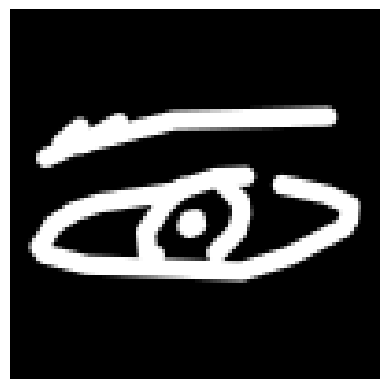

In [4]:
# Visualize a random img file
random_idx = random.randint(0, len(img_data) - 1)
img_file = img_data[random_idx]
visualize_img(img_file)


In [10]:
class ImgTokenDataset(Dataset):
    def __init__(self, raw_img_data, input_length, num_piles = 5):
        N, h, w = raw_img_data.shape
        assert(w%num_piles == 0), "The width of the image must be divisible by the number of piles"
        # raw_img_data = raw_img_data.reshape(N, h, w//num_piles, num_piles)
        self.raw_img_data = raw_img_data/255.0
        # Normalize the data to [0, 1]
        self.raw_img_data = np.clip(self.raw_img_data, 0.001, 0.999)
        # to float32
        self.raw_img_data = self.raw_img_data.astype(np.float32)
        # preprocess
        self.input_data = []
        self.output_data = []
        self.input_length = input_length
        for img_file in self.raw_img_data:
            img_file = img_file.reshape(h, w)
            # transpose
            img_file = np.transpose(img_file)
            img_file = img_file.reshape(w//num_piles, num_piles*h)
            for i in range(0, (w//num_piles) - input_length -1):
                if (not i ==0 )and (not i == (w//num_piles) - input_length -2):
                    if random.random() > 0.5:
                        continue
                input_data = img_file[i:i + input_length]
                # add some noise to the input data
                input_data = input_data + np.random.normal(0, 0.1, input_data.shape).astype(np.float32)
                output_data = img_file[i + input_length]
                self.input_data.append(input_data)
                self.output_data.append(output_data)
        self.input_data = np.array(self.input_data)
        self.output_data = np.array(self.output_data)

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        input_data = self.input_data[idx]
        output_data = self.output_data[idx]
        return input_data, output_data

input_length = 5
picked_num = 5000
num_piles = 4
picked_img = img_data[:picked_num]
img_token_dataset = ImgTokenDataset(picked_img, input_length, num_piles)
img_token_dataloader = DataLoader(img_token_dataset, batch_size=256, shuffle=True)

Input data shape: (5, 400)
Output data shape: (400,)


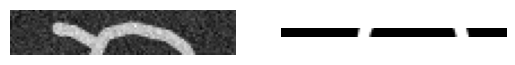

Input data shape: (5, 400)
Output data shape: (400,)


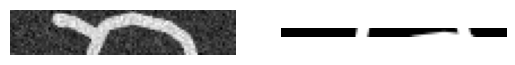

Input data shape: (5, 400)
Output data shape: (400,)


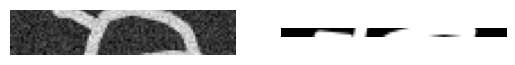

Input data shape: (5, 400)
Output data shape: (400,)


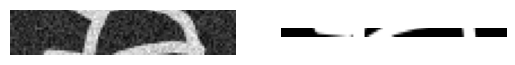

Input data shape: (5, 400)
Output data shape: (400,)


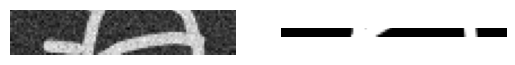

Input data shape: (5, 400)
Output data shape: (400,)


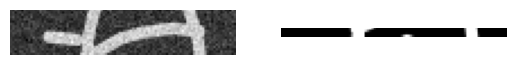

Input data shape: (5, 400)
Output data shape: (400,)


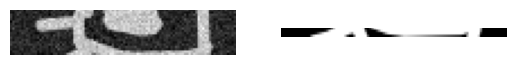

Input data shape: (5, 400)
Output data shape: (400,)


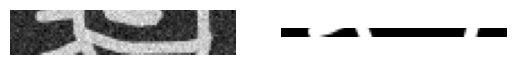

Input data shape: (5, 400)
Output data shape: (400,)


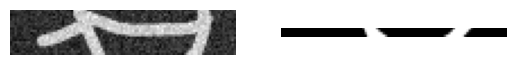

Input data shape: (5, 400)
Output data shape: (400,)


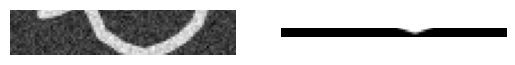

In [11]:
# visualize img_token_dataset
num_samples = 10
for i in range(num_samples):
    input_data, output_data = img_token_dataset[i]
    print(f"Input data shape: {input_data.shape}")
    print(f"Output data shape: {output_data.shape}")
    plt.subplot(1, 2, 1)
    plt.imshow(input_data.reshape(input_length*num_piles, 100), cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(output_data.reshape(num_piles, 100), cmap='gray')
    plt.axis('off')
    plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import math

class PatchEmbedding(nn.Module):
    def __init__(self, patch_size, time_size, embed_dim):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.patch_embedding = nn.Linear(patch_size, embed_dim*2)
        self.patch_embedding2 = nn.Linear(embed_dim*2, embed_dim)
        self.position_embedding = self._get_sine_cosine_embedding(time_size, embed_dim)
        self.relu = nn.ReLU()

    def _get_sine_cosine_embedding(self, seq_len, embed_dim):
        position_embedding = torch.zeros(seq_len, embed_dim)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2).float() * (-math.log(10000.0) / embed_dim))
        position_embedding[:, 0::2] = torch.sin(position * div_term)
        position_embedding[:, 1::2] = torch.cos(position * div_term)
        return position_embedding.unsqueeze(0)  # [1, seq_len, embed_dim]

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        x = self.relu(self.patch_embedding(x))  # [batch_size, seq_len, embed_dim*2]
        x = self.patch_embedding2(x)
        x += self.position_embedding[:, :seq_len, :].to(x.device)  # [1, seq_len, embed_dim]
        return x

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim=64, num_heads=4, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(),
            nn.Linear(4 * embed_dim, embed_dim)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # print("shape of x in TransformerBlock: ", x.shape)
        x_norm = self.norm1(x)
        # print("shape of x_norm in TransformerBlock: ", x_norm.shape)
        attn_output, _ = self.attention(x_norm, x_norm, x_norm)
        x = x + self.dropout(attn_output)
        # print("shape of x after attention: ", x.shape)
        x_norm = self.norm2(x)
        ff_output = self.feed_forward(x_norm)
        x = x + self.dropout(ff_output)
        # print("shape of x after feed forward: ", x.shape)
        return x



class VisionTransformer(nn.Module):
    def __init__(self, patch_size, time_size, embed_dim, num_heads=4, num_layers=6, dropout=0.1):
        super(VisionTransformer, self).__init__()
        self.patch_embedding = PatchEmbedding(patch_size, time_size, embed_dim)
        self.transformer_layers = nn.ModuleList([TransformerBlock(embed_dim, num_heads, dropout) for _ in range(num_layers)])
        self.prediction_head = nn.Linear(embed_dim, embed_dim*2)
        self.prediction_head2 = nn.Linear(embed_dim*2, patch_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.patch_embedding(x)  # [batch_size, 100, embed_dim]
        for layer in self.transformer_layers:
            x = layer(x)
        x = self.relu(self.prediction_head(x))  # [batch_size, 100, patch_size]
        x = self.prediction_head2(x)
        x = self.sigmoid(x)
        return x

In [14]:
import torch.optim as optim
model = VisionTransformer(patch_size = 100*num_piles, time_size = 100//num_piles, embed_dim=32, num_heads=8, num_layers=8, dropout=0.1)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


def train(model, dataloader, optimizer, criterion, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for i, batch in enumerate(img_token_dataloader):
            # print("traning batch ", i, "out of ", len(img_token_dataloader))
            input_tokens, target_tokens = batch
            input_tokens = input_tokens.to(device)
            target_tokens = target_tokens.to(device)
            # print("min in input_tokens: ", input_tokens.min())
            # print("max in input_tokens: ", input_tokens.max())
            optimizer.zero_grad()
            output = model(input_tokens)
            output = output[:,-1,:]
            # print("output shape: ", output.shape)
            # print("target_tokens shape: ", target_tokens.shape)
            loss = criterion(output, target_tokens)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(img_token_dataloader)}")

In [15]:
train(model, img_token_dataloader, optimizer, criterion, device, num_epochs=30)

Epoch 1/30, Loss: 473.619406098301
Epoch 2/30, Loss: 467.3632674726468
Epoch 3/30, Loss: 464.5684334467916
Epoch 4/30, Loss: 464.0364243590716
Epoch 5/30, Loss: 462.7361589450281
Epoch 6/30, Loss: 462.50810819459195
Epoch 7/30, Loss: 461.7728101119254
Epoch 8/30, Loss: 461.46966300890284
Epoch 9/30, Loss: 461.2413251562026
Epoch 10/30, Loss: 460.9437288450963
Epoch 11/30, Loss: 460.60379413493627
Epoch 12/30, Loss: 460.04042053222656
Epoch 13/30, Loss: 459.2724098279638
Epoch 14/30, Loss: 459.0445869223585
Epoch 15/30, Loss: 458.63805085709953
Epoch 16/30, Loss: 458.3168745318663
Epoch 17/30, Loss: 458.2623877664214
Epoch 18/30, Loss: 458.1389268301066
Epoch 19/30, Loss: 457.891670152979
Epoch 20/30, Loss: 457.6178688123388
Epoch 21/30, Loss: 457.0822596874052
Epoch 22/30, Loss: 457.20717065311175
Epoch 23/30, Loss: 457.3295399193625
Epoch 24/30, Loss: 457.34620962791075
Epoch 25/30, Loss: 457.3630462942771
Epoch 26/30, Loss: 457.06798709017556
Epoch 27/30, Loss: 457.1547327134216
Epoc

full_picture shape:  (1, 11, 400)


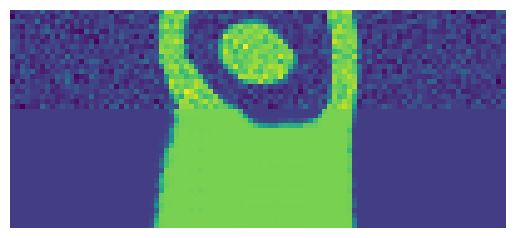

full_picture shape:  (1, 11, 400)


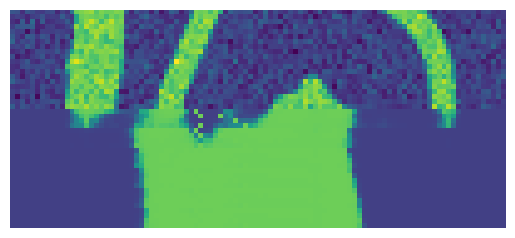

full_picture shape:  (1, 11, 400)


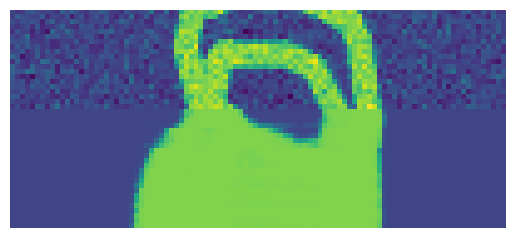

full_picture shape:  (1, 11, 400)


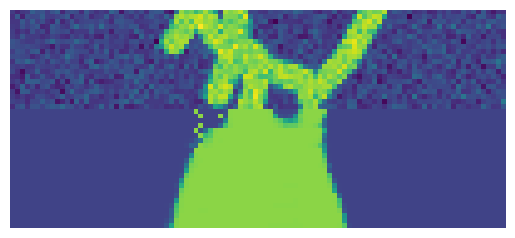

full_picture shape:  (1, 11, 400)


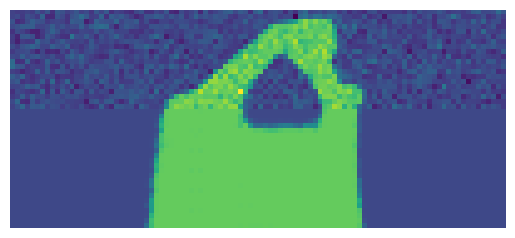

In [61]:
# visualize some results
def visualize_results(model, dataloader, num_samples=5, num_predict = 50):
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= num_samples:
                break
            input_tokens, target_tokens = batch
            input_tokens = input_tokens[0].unsqueeze(0)
            input_tokens = input_tokens.to(device)
            full_picture = input_tokens.cpu().numpy() # [1, 10, 100]
            for j in range(num_predict):
                output = model(input_tokens)
                output = output[:,-1,:]
                input_tokens = torch.cat((input_tokens, output.unsqueeze(0)), dim=1)
                input_tokens = input_tokens[:, 1:, :]
                full_picture = np.concatenate((full_picture, output.unsqueeze(0).cpu().numpy()), axis=1)
            print("full_picture shape: ", full_picture.shape)
            full_picture = full_picture[0]
            h, w = full_picture.shape
            full_picture = full_picture.reshape(h*num_piles, w//num_piles)
            plt.imshow(full_picture)
            plt.axis('off')
            plt.show()
            
visualize_results(model, img_token_dataloader, num_samples=5, num_predict=6)